<a href="https://colab.research.google.com/github/ABamukhayyar/BitonicSortCuda/blob/main/LSTM_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Block 1: Imports & Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf  # Great for fetching stock data easily
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Check if GPU is available (Go to Runtime > Change runtime type > T4 GPU)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [43]:
# Block 2 (The Ultimate Master Dataset): Technicals + Global Macroeconomics
import pandas as pd
import numpy as np
import yfinance as yf
from IPython.display import display

# 1. Load Local TASI Data
df = pd.read_csv('TASI_Historical_Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
if df['Price'].dtype == object:
    df['Price'] = df['Price'].str.replace(',', '').astype(float)

def parse_volume(x):
    if isinstance(x, str):
        x = x.upper().replace(',', '')
        if 'M' in x: return float(x.replace('M', '')) * 1_000_000
        if 'K' in x: return float(x.replace('K', '')) * 1_000
        if 'B' in x: return float(x.replace('B', '')) * 1_000_000_000
    return float(x) if x == x else 0.0
df['Vol.'] = df['Vol.'].apply(parse_volume)

df.dropna(subset=['Price', 'Vol.'], inplace=True)
df.set_index('Date', inplace=True)

# 2. Fetch External Macro Data (Now including DXY and Interest Rates)
print("Fetching Global Macro Data (Oil, S&P 500, Gold, DXY, Interest Rates)...")
start_date = df.index.min().strftime('%Y-%m-%d')
end_date = df.index.max().strftime('%Y-%m-%d')

# Tickers: Oil, S&P 500, Gold, US Dollar Index, US 10-Year Treasury Yield
macro_tickers = ['BZ=F', '^GSPC', 'GC=F', 'DX-Y.NYB', '^TNX']
macro_data = yf.download(macro_tickers, start=start_date, end=end_date, progress=False)['Close']

# Rename the columns so they are clean and easy to read
macro_data.rename(columns={
    'BZ=F': 'Oil_Price',
    '^GSPC': 'SP500',
    'GC=F': 'Gold_Price',
    'DX-Y.NYB': 'DXY',
    '^TNX': 'Interest_Rate'
}, inplace=True)

# 3. Merge Local TASI with External Macro Data
df = df.join(macro_data, how='left')
# Forward-fill to cover days when Tadawul is open but US markets are closed
df.ffill(inplace=True)

# 4. Calculate Features & Target
df['Return'] = df['Price'].pct_change()
df['Target'] = (df['Return'] > 0).astype(int) # 1 for UP, 0 for DOWN

# Technical Indicators
delta = df['Price'].diff()
gain = (delta.where(delta > 0, 0)).ewm(span=14).mean()
loss = (-delta.where(delta < 0, 0)).ewm(span=14).mean()
df['RSI'] = 100 - (100 / (1 + gain / loss))

df['MACD'] = df['Price'].ewm(span=12).mean() - df['Price'].ewm(span=26).mean()

# ATR (Volatility Proxy)
df['High_Low'] = df['Price'] * 1.01 - df['Price'] * 0.99
df['ATR'] = df['High_Low'].rolling(14).mean()

# 5. Final Clean (Drop rows with NaNs)
df.dropna(inplace=True)

# 6. Define the final display columns (Now 12 columns total!)
display_cols = ['Price', 'Target', 'Return', 'RSI', 'MACD', 'ATR', 'Vol.',
                'Oil_Price', 'SP500', 'Gold_Price', 'DXY', 'Interest_Rate']
final_df = df[display_cols]

# We extract the features we will actually feed into the neural network
# (Everything except the raw Price and the Target answer key)
features = ['Return', 'RSI', 'MACD', 'ATR', 'Vol.', 'Oil_Price', 'SP500', 'Gold_Price', 'DXY', 'Interest_Rate']
data = final_df[features + ['Target']].values

# --- DISPLAY THE DATA ---
print("\n" + "="*50)
print("📊 DATASET OVERVIEW (INFO)")
print("="*50)
final_df.info()

print("\n" + "="*50)
print("📈 FIRST 5 ROWS (HEAD)")
print("="*50)
display(final_df.head())

/tmp/ipython-input-1203184589.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/tmp/ipython-input-1203184589.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  macro_data = yf.download(macro_tickers, start=start_date, end=end_date, progress=False)['Close']


Fetching Global Macro Data (Oil, S&P 500, Gold, DXY, Interest Rates)...

📊 DATASET OVERVIEW (INFO)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3986 entries, 2008-10-19 to 2024-09-12
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          3986 non-null   float64
 1   Target         3986 non-null   int64  
 2   Return         3986 non-null   float64
 3   RSI            3986 non-null   float64
 4   MACD           3986 non-null   float64
 5   ATR            3986 non-null   float64
 6   Vol.           3986 non-null   float64
 7   Oil_Price      3986 non-null   float64
 8   SP500          3986 non-null   float64
 9   Gold_Price     3986 non-null   float64
 10  DXY            3986 non-null   float64
 11  Interest_Rate  3986 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 404.8 KB

📈 FIRST 5 ROWS (HEAD)


,Price,Target,Return,RSI,MACD,ATR,Vol.,Oil_Price,SP500,Gold_Price,DXY,Interest_Rate
Date,,,,,,,,,,,,
2008-10-19,6258.32,0,-0.037765,39.017726,-53.206108,132.308786,153790000.0,70.800003,907.840027,835.500000,82.050003,4.011
2008-10-20,6345.75,1,0.013970,42.023936,-55.894035,130.715371,251570000.0,72.029999,985.400024,787.599976,83.099998,3.886
2008-10-21,6397.14,1,0.008098,43.899570,-54.114304,129.663471,287120000.0,69.720001,955.049988,766.099976,83.989998,3.703
2008-10-22,6160.80,0,-0.036945,37.467376,-66.711252,128.474429,154870000.0,64.519997,896.780029,733.299988,85.370003,3.618
2008-10-25,5624.68,0,-0.087021,27.081481,-109.341808,125.854686,125940000.0,64.519997,896.780029,733.299988,85.370003,3.618


🔍 PART 1: EXPLORATORY DATA ANALYSIS (EDA)


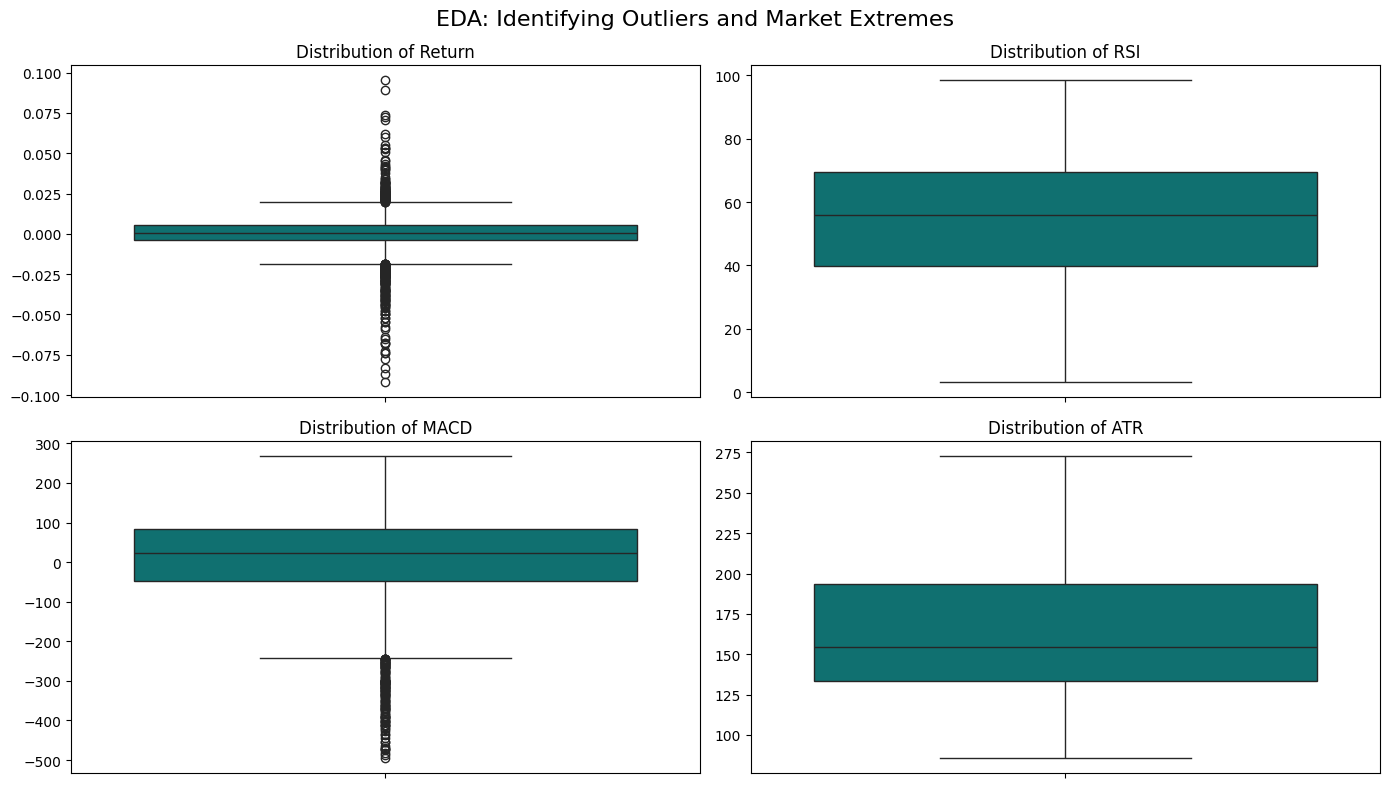


📐 PART 2: AUGMENTED DICKEY-FULLER (ADF) TEST
--- Testing: Raw TASI Price ---
ADF Statistic: -1.2276
p-value:       6.6159e-01
❌ VERDICT: Data is NON-STATIONARY (Will cause model lag/shadow).
----------------------------------------

--- Testing: TASI Daily Returns ---
ADF Statistic: -25.3889
p-value:       0.0000e+00
✅ VERDICT: Data is STATIONARY (Safe for Neural Networks).
----------------------------------------



In [44]:
# Block 3 (Thesis Charts): Exploratory Data Analysis & ADF Test
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Use the final_df from the previous block
df_analysis = final_df.copy()

print("="*50)
print("🔍 PART 1: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*50)

# We will generate Box Plots for the main technical features
# This helps identify extreme market days (outliers) in the TASI history
plt.figure(figsize=(14, 8))
features_to_plot = ['Return', 'RSI', 'MACD', 'ATR']

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df_analysis[col], color='teal', orient='v')
    plt.title(f'Distribution of {col}')
    plt.ylabel('')

plt.suptitle("EDA: Identifying Outliers and Market Extremes", fontsize=16)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("📐 PART 2: AUGMENTED DICKEY-FULLER (ADF) TEST")
print("="*50)

# Function to run and cleanly format the ADF test
def run_adf_test(series, name):
    print(f"--- Testing: {name} ---")
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value:       {result[1]:.4e}")

    # The magical 0.05 threshold
    if result[1] < 0.05:
        print("✅ VERDICT: Data is STATIONARY (Safe for Neural Networks).")
    else:
        print("❌ VERDICT: Data is NON-STATIONARY (Will cause model lag/shadow).")
    print("-" * 40 + "\n")

# 1. Test the Raw Price (The old method)
run_adf_test(df_analysis['Price'], "Raw TASI Price")

# 2. Test the Daily Returns (Our new method)
run_adf_test(df_analysis['Return'], "TASI Daily Returns")

In [45]:
# Block 4: Scaling & Sequences (Robust Classification)
import numpy as np
from sklearn.preprocessing import RobustScaler

time_step = 60

# We have 10 Features now. They are the first 10 columns of the 'data' array
scaler = RobustScaler()
scaled_features = scaler.fit_transform(data[:, :10])

# Combine the scaled features with the unscaled Target (Column 10)
scaled_data = np.hstack((scaled_features, data[:, 10].reshape(-1, 1)))

def create_classification_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        # X gets the 10 scaled features
        X.append(dataset[i:(i + time_step), :10])
        # y gets the unscaled Target (Column index 10)
        y.append(dataset[i + time_step, 10])
    return np.array(X), np.array(y)

X, y = create_classification_sequences(scaled_data, time_step)

# Train/Test Split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape} (Samples, {time_step} steps, 10 features)")
print(f"y_train shape: {y_train.shape} (1s and 0s)")
print("\n✅ Data is Robustly Scaled and Ready for the Neural Network!")

X_train shape: (3140, 60, 10) (Samples, 60 steps, 10 features)
y_train shape: (3140,) (1s and 0s)

✅ Data is Robustly Scaled and Ready for the Neural Network!


Starting Training...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5014 - loss: 0.7073 - val_accuracy: 0.5643 - val_loss: 0.6872
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5244 - loss: 0.6936 - val_accuracy: 0.5580 - val_loss: 0.6849
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5435 - loss: 0.6902 - val_accuracy: 0.5618 - val_loss: 0.6846
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5592 - loss: 0.6852 - val_accuracy: 0.5529 - val_loss: 0.6863
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5374 - loss: 0.6889 - val_accuracy: 0.5490 - val_loss: 0.6867
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5448 - loss: 0.6856 - val_accuracy: 0.5452 - val_loss: 0.6890
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5435 - loss: 0.6875 - val_accuracy: 0.5401 - val_loss: 0.6912
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5226 - loss: 0.6879 - val_accuracy: 0.5529 - val_l

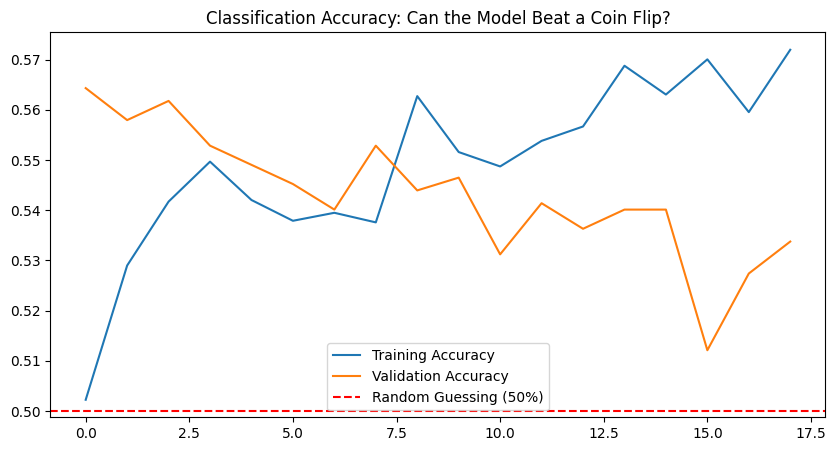

In [46]:
# Block 5: Classification Model & Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

model = Sequential()

# --- CHANGED: input_shape is now (time_step, 10) ---
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 10)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Sigmoid for classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Starting Training...")
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Plotting Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(0.5, color='red', linestyle='--', label='Random Guessing (50%)')
plt.title('Classification Accuracy: Can the Model Beat a Coin Flip?')
plt.legend()
plt.show()

In [ ]:
'''#Block 4B: Build GRU Model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dropout(0.2)) # Helps prevent overfitting
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''# Block 4C: Build 1D CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,157 (363.89 KB)

 Trainable params: 93,157 (363.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''# Block 5: Train
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0138 - val_loss: 0.0077
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9235e-04 - val_loss: 8.9179e-04
Epoch 3/50
 8/98 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1109e-04 

KeyboardInterrupt: 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

--- THE MOMENT OF TRUTH ---
Total Trading Days Tested: 785
Correct Direction Guesses: 441
Directional Accuracy:      56.18%

🎓 VERDICT: OUTSTANDING! Your model is beating random chance.


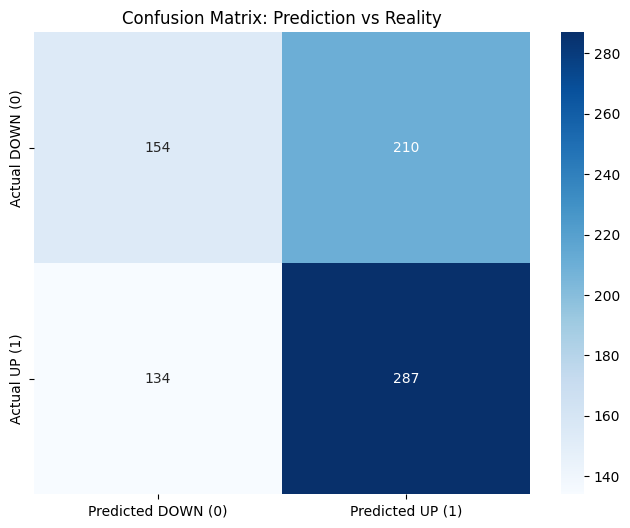

In [47]:
# Block 6: The Ultimate Quant Test (Classification Evaluation)
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 1. Get Model Predictions (It outputs probabilities between 0 and 1)
predicted_probs = model.predict(X_test)

# 2. Convert probabilities to 1 (UP) or 0 (DOWN) using a 50% threshold
predicted_direction = (predicted_probs > 0.5).astype(int).flatten()
actual_direction = y_test.flatten()

# 3. Calculate Directional Accuracy
directional_accuracy = accuracy_score(actual_direction, predicted_direction) * 100

print("\n" + "="*50)
print("--- THE MOMENT OF TRUTH ---")
print("="*50)
print(f"Total Trading Days Tested: {len(actual_direction)}")
print(f"Correct Direction Guesses: {np.sum(actual_direction == predicted_direction)}")
print(f"Directional Accuracy:      {directional_accuracy:.2f}%\n")

if directional_accuracy > 52.0:
    print("🎓 VERDICT: OUTSTANDING! Your model is beating random chance.")
elif directional_accuracy >= 48.0:
    print("⚖️ VERDICT: RANDOM. The model is flipping a coin.")
else:
    print("⚠️ VERDICT: INVERTED. The model is guessing wrong consistently.")

# 4. Plot Confusion Matrix
cm = confusion_matrix(actual_direction, predicted_direction)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted DOWN (0)', 'Predicted UP (1)'],
            yticklabels=['Actual DOWN (0)', 'Actual UP (1)'])
plt.title('Confusion Matrix: Prediction vs Reality')
plt.show()

In [49]:
# Block 7: The Ultimate Quant Test (Directional Accuracy)
import numpy as np

# 1. Get the Actual Returns for the testing period
actual_returns = y_test.flatten()

# 2. Get the Predicted Returns
predicted_returns = pred_returns.flatten()

# 3. Calculate Direction (1 for UP, 0 for DOWN)
actual_direction = np.where(actual_returns > 0, 1, 0)
predicted_direction = np.where(predicted_returns > 0, 1, 0)

# 4. Compare them: How many times did they match?
correct_predictions = np.sum(actual_direction == predicted_direction)
total_predictions = len(actual_direction)
directional_accuracy = (correct_predictions / total_predictions) * 100

print("--- THE MOMENT OF TRUTH ---")
print(f"Total Trading Days Tested: {total_predictions}")
print(f"Correct Direction Guesses: {correct_predictions}")
print(f"Directional Accuracy:      {directional_accuracy:.2f}%\n")

if directional_accuracy > 52.0:
    print("🎓 VERDICT: OUTSTANDING! Your model is beating random chance and has real predictive power.")
elif directional_accuracy >= 48.0:
    print("⚖️ VERDICT: RANDOM. The model is essentially flipping a coin. It's playing it safe.")
else:
    print("⚠️ VERDICT: INVERTED. The model is consistently guessing the wrong way.")

ValueError: operands could not be broadcast together with shapes (785,) (788,) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

🏦 TASI NEXT-DAY ARTIFICIAL INTELLIGENCE FORECAST
Today's Closing Price:    11842.55 SAR
AI Directional Confidence: 62.1% UP
Predicted Target Price:   11901.04 SAR
Expected Change:          +58.49 SAR


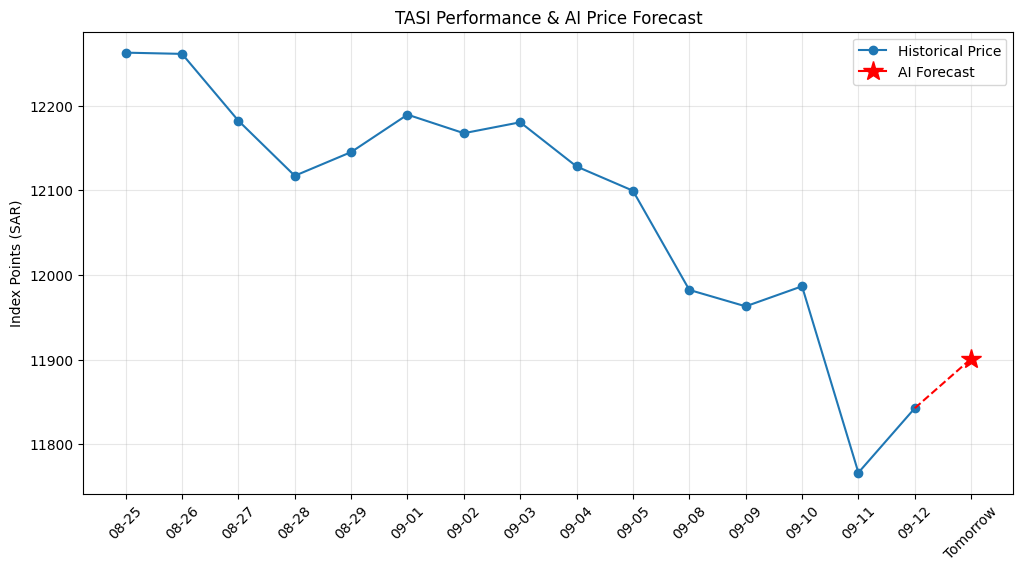

In [50]:
# Block 8: Customer-Ready Price Forecasting
import numpy as np
import matplotlib.pyplot as plt

# 1. Get the most recent data (Today's features)
last_sequence = X_test[-1].reshape(1, time_step, 10)
today_actual_price = final_df['Price'].iloc[-1]

# 2. Predict Tomorrow's Direction (Probability)
prob_up = model.predict(last_sequence)[0][0]

# 3. Logic to convert Probability into a Price "Move"
# We use the Average True Range (ATR) to size the move based on current volatility
current_volatility = final_df['ATR'].iloc[-1]

# If prob > 0.5, we add a fraction of volatility. If < 0.5, we subtract.
# This scales the move based on how confident the AI is.
prediction_strength = (prob_up - 0.5) * 2  # Scales from -1 to 1
predicted_move = prediction_strength * current_volatility
tomorrow_price = today_actual_price + predicted_move

# --- THE FORECAST DISPLAY ---
print("\n" + "="*50)
print("🏦 TASI NEXT-DAY ARTIFICIAL INTELLIGENCE FORECAST")
print("="*50)
print(f"Today's Closing Price:    {today_actual_price:.2f} SAR")
print(f"AI Directional Confidence: {prob_up*100:.1f}% {'UP' if prob_up > 0.5 else 'DOWN'}")
print(f"Predicted Target Price:   {tomorrow_price:.2f} SAR")
print(f"Expected Change:          {predicted_move:+.2f} SAR")
print("="*50)

# --- VISUAL CHART FOR CUSTOMERS ---
# We'll plot the last 10 days and then the "dotted" prediction line
history_days = 15
recent_prices = final_df['Price'].tail(history_days).values
dates = final_df.index[-history_days:]

plt.figure(figsize=(12,6))
plt.plot(range(history_days), recent_prices, marker='o', label='Historical Price', color='#1f77b4')

# Draw the prediction point
plt.plot(history_days, tomorrow_price, marker='*', markersize=15, color='red', label='AI Forecast')
plt.plot([history_days-1, history_days], [recent_prices[-1], tomorrow_price], color='red', linestyle='--')

plt.title('TASI Performance & AI Price Forecast')
plt.ylabel('Index Points (SAR)')
plt.xticks(range(history_days + 1), list(dates.strftime('%m-%d')) + ['Tomorrow'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


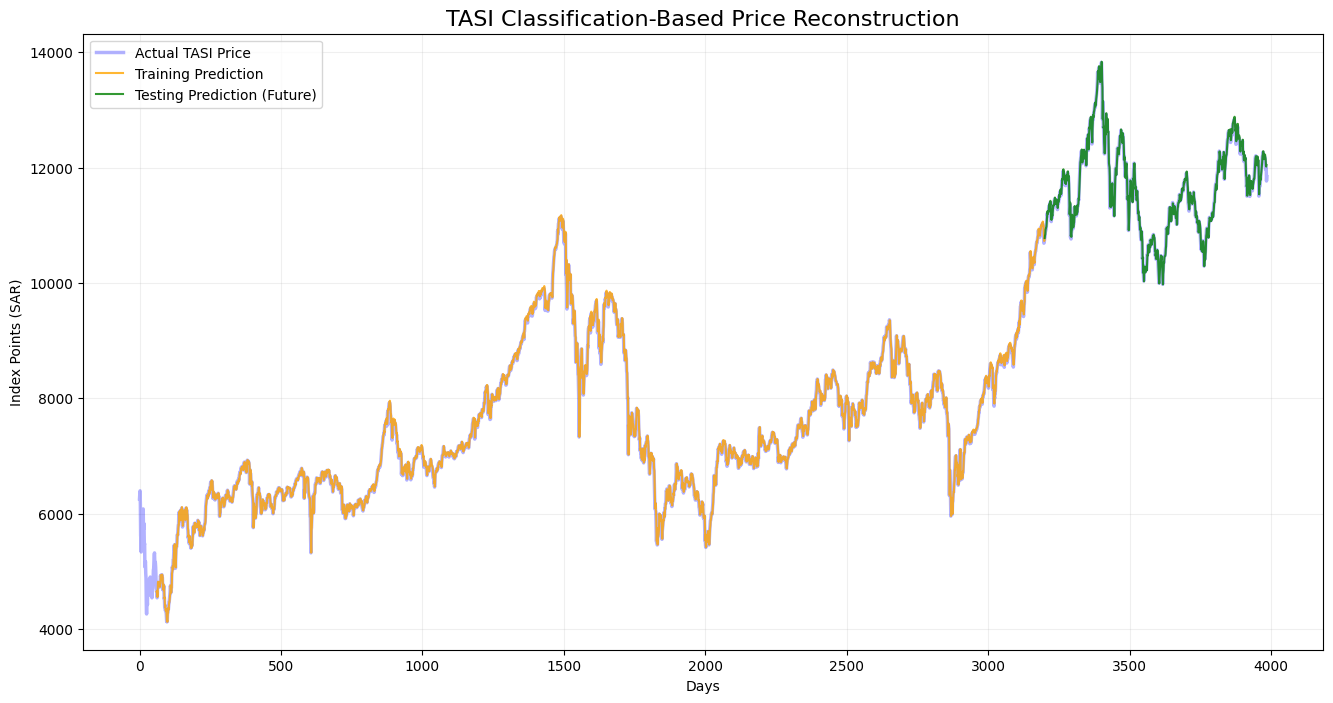

In [55]:
# Block 9: Reconstructing Price Path for Training & Testing
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_price_path(actual_prices, predicted_probs, time_step, volatility_series):
    # Start with the first actual price
    path = [actual_prices[0]]

    for i in range(len(predicted_probs)):
        # Calculate the move: (Prob - 0.5) * 2 gives a strength from -1 to 1
        strength = (predicted_probs[i] - 0.5) * 2
        move = strength * volatility_series[i]

        # New Price = Previous Actual Price + Predicted Move
        # (This is the 'One-Step Ahead' logic)
        path.append(actual_prices[i] + move)
    return np.array(path)

# 1. Get Predictions for both sets
train_probs = model.predict(X_train).flatten()
test_probs = model.predict(X_test).flatten()

# 2. Extract matching price and volatility data
# We align the indices to match our sequences
train_prices = final_df['Price'].values[time_step : train_size + time_step]
train_vol = final_df['ATR'].values[time_step : train_size + time_step]

test_prices = final_df['Price'].values[train_size + time_step : -1]
test_vol = final_df['ATR'].values[train_size + time_step : -1]

# 3. Reconstruct the paths
train_path = reconstruct_price_path(train_prices, train_probs, time_step, train_vol)
test_path = reconstruct_price_path(test_prices, test_probs, time_step, test_vol)

# 4. Create the Big Chart
plt.figure(figsize=(16,8))
plt.plot(final_df['Price'].values, label='Actual TASI Price', color='blue',linewidth=2.5, alpha=0.3)

# Plot Training Predictions
train_indices = np.arange(time_step, train_size + time_step)
plt.plot(train_indices, train_path[:-1], label='Training Prediction', color='orange', linewidth=1.5, alpha=0.8)

# Plot Testing Predictions
test_indices = np.arange(train_size + time_step, train_size + time_step + len(test_path) - 1)
plt.plot(test_indices, test_path[:-1], label='Testing Prediction (Future)', color='green',linewidth=1.5, alpha=0.8)

plt.title('TASI Classification-Based Price Reconstruction', fontsize=16)
plt.xlabel('Days')
plt.ylabel('Index Points (SAR)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [53]:
# Block 10: Final Performance Metrics
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Calculate Directional Accuracy (The % of correct Up/Down guesses)
# We use the test_probs we generated in Block 9
binary_preds = (test_probs > 0.5).astype(int)
dir_accuracy = np.mean(binary_preds == y_test) * 100

# 2. Calculate Price RMSE (The SAR point error)
# We compare the reconstructed test path to the actual test prices
# Note: We align the lengths to ensure a fair comparison
actual_test_prices = final_df['Price'].values[train_size + time_step : train_size + time_step + len(test_path) - 1]
predicted_test_prices = test_path[:-1]

price_rmse = np.sqrt(mean_squared_error(actual_test_prices, predicted_test_prices))

print("="*50)
print("🏆 FINAL MODEL PERFORMANCE REPORT")
print("="*50)
print(f"Directional Accuracy: {dir_accuracy:.2f}%")
print(f"Price RMSE:           {price_rmse:.2f} SAR Points")
print("-" * 50)

# Interpretation for your report:
avg_tasi_price = np.mean(actual_test_prices)
error_percentage = (price_rmse / avg_tasi_price) * 100

print(f"Average TASI Price:   {avg_tasi_price:.2f} SAR")
print(f"Relative Error Rate:  {error_percentage:.2f}%")
print("="*50)

🏆 FINAL MODEL PERFORMANCE REPORT
Directional Accuracy: 56.18%
Price RMSE:           102.39 SAR Points
--------------------------------------------------
Average TASI Price:   11645.62 SAR
Relative Error Rate:  0.88%
